https://towardsdatascience.com/cuda-by-numba-examples-1-4-e0d06651612f

In [2]:
import numpy as np
import numba
from numba import cuda 
print(np.__version__)
print(numba.__version__)
cuda.detect()

1.24.1
0.58.0
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3060 Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-68a58ec2-b3d2-d27c-1c94-4dbdcb4b8ee0
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
# Example 1.1: Add scalars
@cuda.jit
def add_scalars(a, b, c):
    c[0] = a + b

dev_c = cuda.device_array((1,), np.float32)

add_scalars[1, 1](2.0, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")
#  2.0 + 7.0 = 9.0

/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


2.0 + 7.0 = 9.0


In [4]:
# Example 1.2: Add arrays
@cuda.jit
def add_array(a, b, c):
    i = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if i < a.size:
        c[i] = a[i] + b[i]

N = 20
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)
dev_c = cuda.device_array_like(a)

add_array[4, 8](a, b, dev_c)

c = dev_c.copy_to_host()
print(c)

#  [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38.]

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.8/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [6]:
# Example 1.3: Add arrays with cuda.grid
@cuda.jit
def add_array(a, b, c):
    i = cuda.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]

add_array[4, 8](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
print(c)

[0.000000e+00 2.000000e+00 4.000000e+00 ... 1.999994e+06 1.999996e+06
 1.999998e+06]


/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [7]:
N = 1_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)
dev_c = cuda.device_array_like(a)

threads_per_block = 256
blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block
# Note that
#     blocks_per_grid == ceil(N / threads_per_block)
# ensures that blocks_per_grid * threads_per_block >= N

add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

#  True

True

In [20]:
""" 
In cases where the number of blocks per grid exceeds the hardware limit but the array fits in memory, 
instead of using one thread per array element, we can use one thread to process several elements. 
The idea behind this technique is to add a loop inside of the CUDA kernel 
to process multiple input elements. The stride of this loop, as the name implies, 
is equal to the number of threads in a grid. This way, if the total number 
of threads in the grid (threads_per_grid = blockDim.x * gridDim.x) is smaller than 
the number of elements of the array, as soon as the kernel is done processing 
the index cuda.grid(1) it will process the index cuda.grid(1) + threads_per_grid 
and so on until all array elements have been processed. 
"""


# Example 1.4: Add arrays with grid striding
@cuda.jit
def add_array_gs(a, b, c):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

threads_per_block = 256
blocks_per_grid_gs = 32 * 30  # Use 32 * multiple of streaming multiprocessors
# 32 * 80 * 256 < 1_000_000 so one thread will process more than one array element

add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
c = dev_c.copy_to_host()
np.allclose(a + b, c)

#  True

True

In [21]:
#Timing CUDA Kernels
from time import perf_counter_ns

# Compile and then clear GPU from tasks
add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)
cuda.synchronize()

timing = np.empty(101)
for i in range(timing.size):
    tic = perf_counter_ns()
    add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)
    cuda.synchronize()
    toc = perf_counter_ns()
    timing[i] = toc - tic
timing *= 1e-3  # convert to μs

print(f"Elapsed time: {timing.mean():.0f} ± {timing.std():.0f} μs")

#  Elapsed time: 201 ± 109 μs

Elapsed time: 1442 ± 3034 μs


In [22]:
# Compile and then clear GPU from tasks
add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
cuda.synchronize()

timing_gs = np.empty(101)
for i in range(timing_gs.size):
    tic = perf_counter_ns()
    add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
    cuda.synchronize()
    toc = perf_counter_ns()
    timing_gs[i] = toc - tic
timing_gs *= 1e-3  # convert to μs

print(f"Elapsed time: {timing_gs.mean():.0f} ± {timing_gs.std():.0f} μs")

Elapsed time: 221 ± 179 μs


In [23]:
#              G * FLOP       / timing in s
gflops    = 1e-9 * dev_a.size * 1e6 / timing.mean()
gflops_gs = 1e-9 * dev_a.size * 1e6 / timing_gs.mean()

print(f"GFLOP/s (algo 1): {gflops:.2f}")
print(f"GFLOP/s (algo 2): {gflops_gs:.2f}")


GFLOP/s (algo 1): 0.69
GFLOP/s (algo 2): 4.52


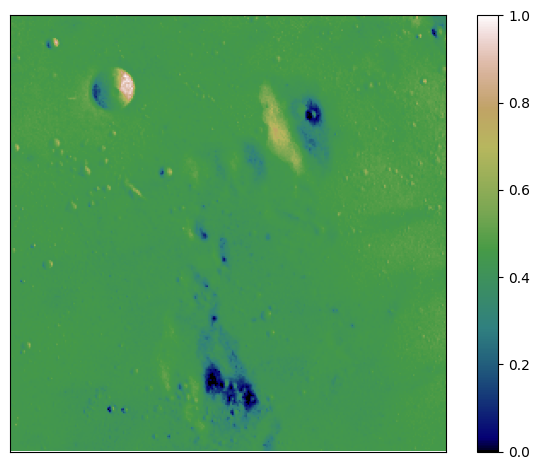

In [16]:
import matplotlib.pyplot as plt
from skimage import data

moon = data.moon().astype(np.float32) / 255.

fig, ax = plt.subplots()
im = ax.imshow(moon, cmap="gist_earth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

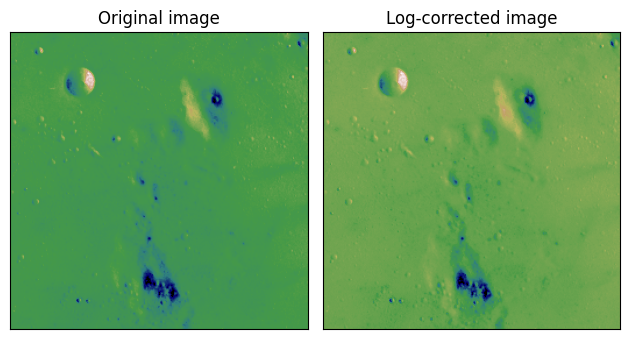

In [18]:
import math
# Example 1.5: 2D kernel
@cuda.jit
def adjust_log(inp, gain, out):
    ix, iy = cuda.grid(2) # The first index is the fastest dimension
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #  threads per grid dimension
    
    n0, n1 = inp.shape # The last index is the fastest dimension
    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1 + inp[i0, i1])

threads_per_block_2d = (16, 16)  #  256 threads total
blocks_per_grid_2d = (64, 64)

moon_gpu = cuda.to_device(moon)
moon_corr_gpu = cuda.device_array_like(moon_gpu)

adjust_log[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 1.0, moon_corr_gpu)
moon_corr = moon_corr_gpu.copy_to_host()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(moon_corr, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()

Let us make note of the two for loops. Notice that that the first for loop starts at iy and the second, innermost loop starts at ix. We could have easily chosen i0 to start at ix and i1 to start at iy instead, which would even feel more natural. So why did we choose this order? It turns out that the memory access pattern for the first choice is more efficient. Since the first grid index is the fastest one, we want to make it match our fastest dimension: the last one.

In [19]:
from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit

# Initialize CUDA Driver API
(err,) = cuInit(0)

# Get attributes
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

print(f"Device Name: {DEVICE_NAME}")
print(f"Maximum number of multiprocessors: {SMs}")
print(f"Maximum number of threads per block: {MAX_THREADS_PER_BLOCK:10}")
print(f"Maximum number of blocks per grid:   {MAX_BLOCK_DIM_X:10}")
print(f"Maximum number of threads per grid:  {MAX_GRID_DIM_X:10}")

Device Name: NVIDIA GeForce RTX 3060 Laptop GPU                                                                                             
Maximum number of multiprocessors: 30
Maximum number of threads per block:       1024
Maximum number of blocks per grid:         1024
Maximum number of threads per grid:  2147483647
